In [199]:
%reload_ext autoreload

In [768]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score, cohen_kappa_score, mean_absolute_error
from tabulate import tabulate
import numpy as np
from sklearn.model_selection import GridSearchCV
import random
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
from imblearn.over_sampling import SMOTE

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [769]:
# Load in data

PATH = "../../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

In [770]:
#df_raw = df_raw.sort('licence_registration_date')
df_raw = df_raw.sort_values(by='licence_registration_date')

#df_raw.licence_registration_date.head(5), df_raw.licence_registration_date.tail(5)

In [771]:
# Convert annual_revenue from a string to a float

df_raw['annual_revenue'] = pd.to_numeric(df_raw['annual_revenue'].str.replace(',', ''))

In [772]:
len(df_raw[df_raw['churned'] == 1]), len(df_raw[df_raw['churned'] == 0])

(3109, 2780)

In [773]:
def data_summary(df_raw):
    array = []
    for column_name in df_raw.select_dtypes(include=['float64', 'int64']).columns:
        mean = df_raw[column_name].mean()
        median = df_raw[column_name].median()
        std = df_raw[column_name].std()
        cv = df_raw[column_name].std()/df_raw[column_name].mean()
        trimmed_mean = trim_mean(df_raw[column_name].values, 0.1)
        array.append([column_name, mean, median, std, cv, trimmed_mean])
    print(tabulate(array,headers=['Column', 'Mean', 'Median', 'Std', 'cv', 'Trimmed Mean']))
    
data_summary(df_raw)

Column                                     Mean    Median             Std        cv    Trimmed Mean
-------------------------------  --------------  --------  --------------  --------  --------------
days_active                         679.202         525     564.891        0.831698      610.381
nps                                   4.40672         5       3.5339       0.801936      nan
last_login_days                      26.1673          0      59.6729       2.28044       nan
last_login_concern                    0.287724        0       0.452774     1.57364       nan
golive_days                          67.6303          4     142.993        2.11433        33.6183
cases_total                           9.12935         5      13.0971       1.43462       nan
cases_open                            0.791624        0       1.37527      1.73727       nan
cases_closed                          0.791624        0       1.37527      1.73727       nan
cases_age_hours_total              2298.93     

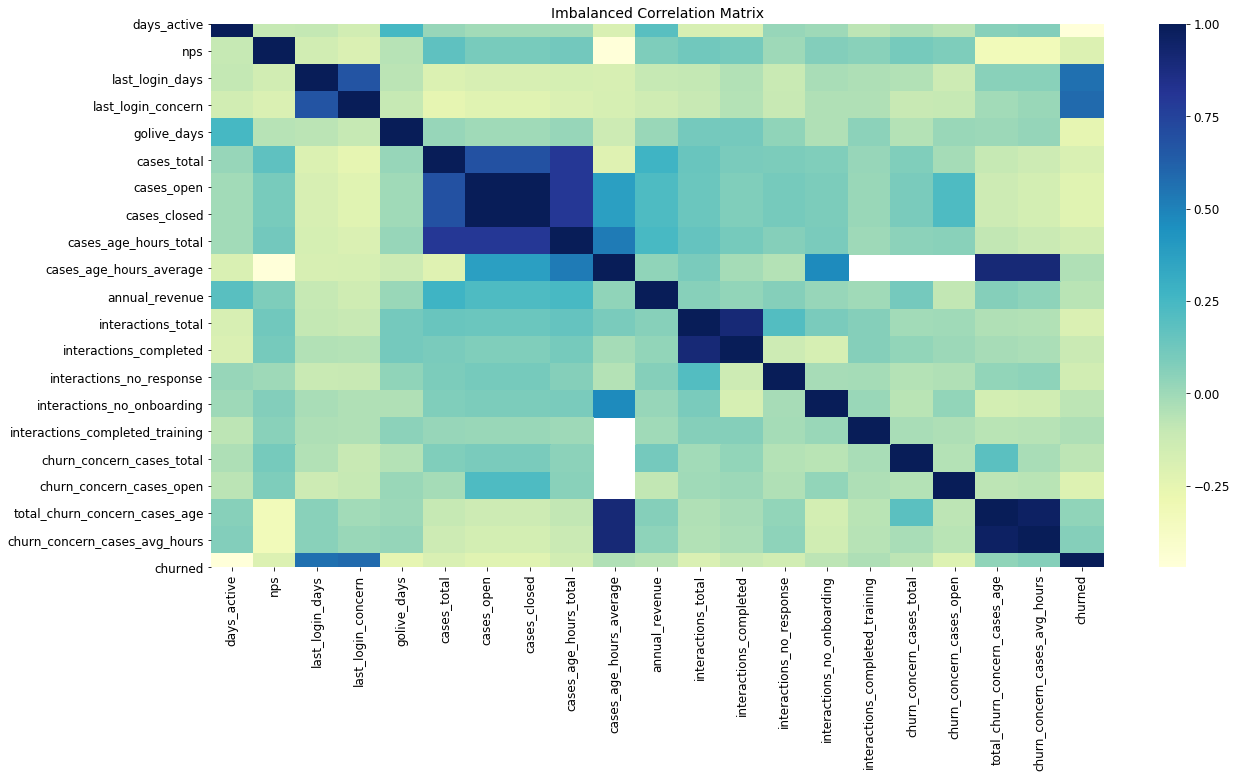

In [774]:
def graph_corr(df):
    # Sample figsize in inches
    fig, ax = plt.subplots(figsize=(20,10))         # Imbalanced DataFrame Correlation
    corr = df.corr()
    sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
    ax.set_title("Imbalanced Correlation Matrix", fontsize=14)
    plt.show()

graph_corr(df_raw)

In [775]:
# Convert fields to INT and setting any NaNs to the mean of that type
case_types = ['cases_total','cases_open','cases_closed','cases_age_hours_total','cases_age_hours_average', 'last_login_days']

for case_type in case_types:
    default_value = df_raw[case_type].fillna(df_raw[case_type].median())
    df_raw[case_type] = df_raw[case_type].fillna(default_value).astype(int)

In [776]:
plan_list = df_raw.plan[~pd.isnull(df_raw.plan)].unique()

for plan in plan_list:
    mean = round(df_raw.annual_revenue[df_raw.plan == plan].mean(), 2)
    trimmed_mean = trim_mean(df_raw.annual_revenue[df_raw.plan == plan].values, 0.1)
    
    if pd.isnull(plan_revenue_mean):
        revenue = 0
    else:
        revenue = mean
    df_raw.loc[df_raw.plan==plan, 'annual_revenue'] = df_raw.loc[df_raw.plan==plan, 'annual_revenue'].fillna(revenue)

In [777]:
# 'binning' - grouping continous data into 'bins'

bins = [1, 3, 7, 14, 30, 60]
group_names = ['day', 'few_days', 'week', 'fortnight', 'month']

# need to get the mean of the plan size for last_login_days and set each row to that
#df_raw.last_login_days = df_raw.last_login_days.fillna(np.mean(df_raw.last_login_days))

last_login_categories = pd.cut(df_raw['last_login_days'], bins, labels=group_names)
df_raw['last_login_categories'] = pd.cut(df_raw['last_login_days'], bins, labels=group_names)
pd.value_counts(df_raw['last_login_categories'])

few_days     174
month        143
week         125
fortnight    114
day           80
Name: last_login_categories, dtype: int64

In [778]:
# A more standard way to one-hot encoding

dummy_columns = ['customer_account_status', 'last_login_categories', 'plan']

for dummy_column in dummy_columns:
    print(dummy_column)
    dummy = pd.get_dummies(df_raw[dummy_column], prefix=dummy_column)
    df_raw = pd.concat([df_raw,dummy], axis=1)
    df_raw = df_raw.drop(columns=dummy_column)

customer_account_status
last_login_categories
plan


In [779]:
# These steps can only be run once then you need to comment them out

#add_datepart(df_raw, 'canceldate')
add_datepart(df_raw, 'licence_registration_date')
add_datepart(df_raw, 'golive_date')

In [780]:
pd.option_context("display.max_rows", 1000, "display.max_columns", 1000)

In [781]:
# Drop columns

df_raw = df_raw.drop(columns=['customer_account_status_Good', 'last_login_concern',
                              'last_login_days', 'account_status', 'changing_platform', 
                              'new_platform', 'licence_status', 'canceldate', 
                              'cancel_details', 'cancel_reason'])



In [782]:
# Set default values for NaN values

df_raw.nps = df_raw.nps.fillna(np.nanmean(df_raw.nps))

# Set NaN to zero

features = ['churned', 'interactions_total', 'interactions_completed', 'interactions_no_response', 'interactions_no_onboarding', 'interactions_completed_training']

for feature in features:
    df_raw[feature] = df_raw[feature].fillna(0)


In [783]:
# Complete the transformation of all data into numbers using proc_df and create training dataframes
train_cats(df_raw)

In [784]:
df_trn, y_trn, nas = proc_df(df_raw, 'churned')

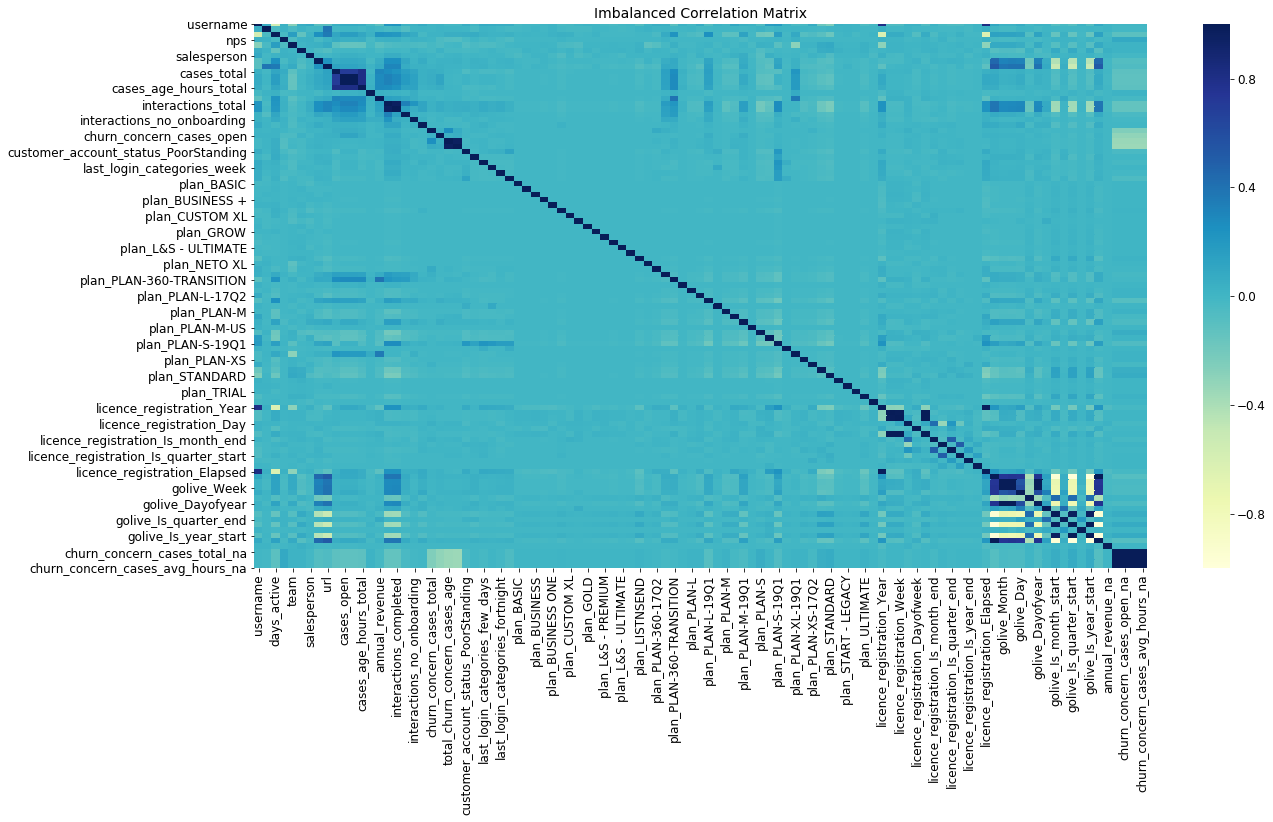

In [785]:
graph_corr(df_trn)

In [786]:
data_summary(df_trn)

Column                                       Mean          Median             Std            cv     Trimmed Mean
-------------------------------  ----------------  --------------  --------------  ------------  ---------------
days_active                         679.202         525             564.891         0.831698       610.381
nps                                   4.40672         4.40672         1.06524       0.241731         4.40672
golive_days                          67.6303          4             142.993         2.11433         33.6183
cases_total                           7.07624         5               9.51299       1.34436          5.18141
cases_open                            0.39803         0               1.05238       2.64398          0.146404
cases_closed                          0.39803         0               1.05238       2.64398          0.146404
cases_age_hours_total              1754.53         1204            2402.69          1.36942       1285.28
cases_age_hours

In [787]:
# Using mean
#annual_revenue                   281057               0               1.49475e+06   5.31833      41718.7

# Using trimmed mean
#annual_revenue                   294829            24976.6             1.49366e+06   5.06618      57409.2

In [788]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)

In [789]:
len(X_valid), len(X_valid.columns), len(X_train), len(X_train.columns)

(500, 103, 5389, 103)

In [790]:
y_train, y_valid = split_vals(y_trn, n_trn)
len(y_valid), len(y_train)

(500, 5389)

In [791]:
len([1 for i in y_train if i > 0]), len([1 for i in y_train if i == 0])

(3028, 2361)

In [792]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [793]:
len([1 for i in y_train_res if i > 0]), len([1 for i in y_train_res if i == 0])

(3028, 3028)

In [794]:
tune = False

In [795]:
if tune:
    # Create the hyperparameter grid
    param_grid = {#'max_features': ['auto', 'sqrt', 'log2'],
                  'min_samples_leaf': np.arange(1,3),
                  'n_estimators': np.arange(1,10),
                  'class_weight':[{0: w} for w in [1, 2, 3, 5, 10, 20]],
                  #'bootstrap': [True, False],
                  'criterion': ['gini', 'entropy'],
                  'max_depth': [None, 1, 2, 3]
                 }

    # Call GridSearchCV
    grid_search = GridSearchCV(RandomForestClassifier(), param_grid)

    # Fit the model
    grid_search.fit(X_valid, y_valid)

    print(grid_search.best_params_, grid_search.best_score_)

In [796]:
m = RandomForestClassifier(
    n_estimators=200,
    min_samples_leaf=1, 
    max_features='sqrt',
    n_jobs=-1, 
    #oob_score=True,
    max_depth=3,
    bootstrap=False,
    criterion='gini',
    class_weight={0: 2, 1: 1})

m.fit(X_train_res, y_train_res)

RandomForestClassifier(bootstrap=False, class_weight={0: 2, 1: 1},
                       criterion='gini', max_depth=3, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=200, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [797]:
validate_predictions = m.predict(X_valid)

In [820]:
def uber_score(y_valid, validate_predictions):
    #cm = confusion_matrix(y_valid, validate_predictions)
    #print(cm)
    #print('true positives, false positives, false negatives, true negatives')
    #print("P:",precision_score(y_valid,validate_predictions), "R", recall_score(y_valid,validate_predictions), "f1:", f1_score(y_valid,validate_predictions), "accur:", accuracy_score(y_valid,validate_predictions), "kappa:", cohen_kappa_score(y_valid,validate_predictions), "mae:", mean_absolute_error(y_valid,validate_predictions)
    return [precision_score(y_valid,validate_predictions), recall_score(y_valid,validate_predictions), f1_score(y_valid,validate_predictions), accuracy_score(y_valid,validate_predictions), cohen_kappa_score(y_valid,validate_predictions), mean_absolute_error(y_valid,validate_predictions)]

In [821]:
uber_score(y_valid, validate_predictions)

[0.43410852713178294,
 0.691358024691358,
 0.5333333333333333,
 0.804,
 0.41737414092411596,
 0.196]

In [800]:
# Cohen's kappa coefficient (κ) is a statistic that
# is used to measure inter-rater reliability (and also Intra-rater reliability)
# for qualitative (categorical) items

cohen_kappa_score(y_valid,validate_predictions), mean_absolute_error(y_valid,validate_predictions)

(0.41737414092411596, 0.196)

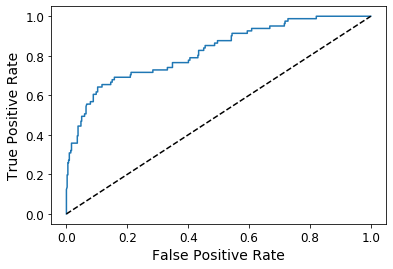

In [801]:
# Generate the probabilities
y_pred_prob = m.predict_proba(X_valid)[:, 1]

# Calculate the roc metrics
fpr, tpr, thresholds = roc_curve(y_valid, y_pred_prob)

# Plot the ROC curve
plt.plot(fpr,tpr)

# Add labels and diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

In [802]:
# Print the AUC
auc = roc_auc_score(y_valid, y_pred_prob)
print(auc)

0.8229175874362827


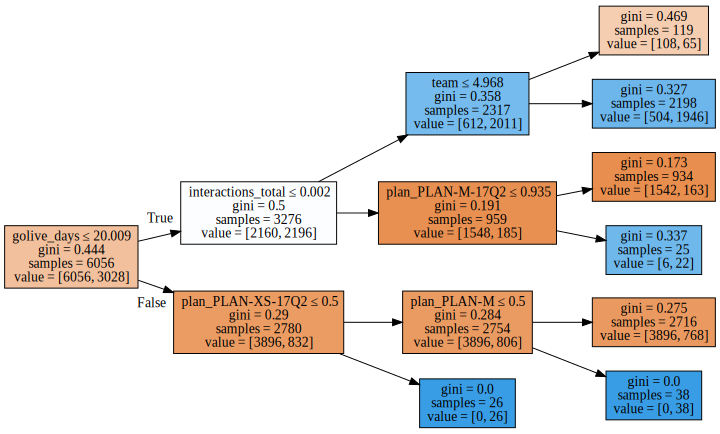

In [803]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [804]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
14,annual_revenue,0.158808
2,days_active,0.155650
15,interactions_total,0.110687
16,interactions_completed,0.087134
9,cases_total,0.065757
12,cases_age_hours_total,0.060279
11,cases_closed,0.048881
10,cases_open,0.042402
60,plan_PLAN-S-19Q1,0.040610
8,url,0.029953


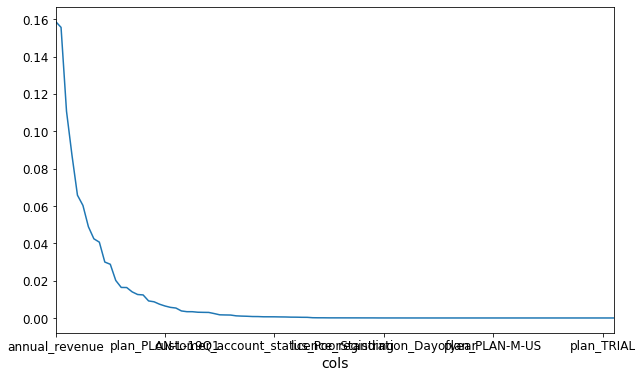

In [805]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [806]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

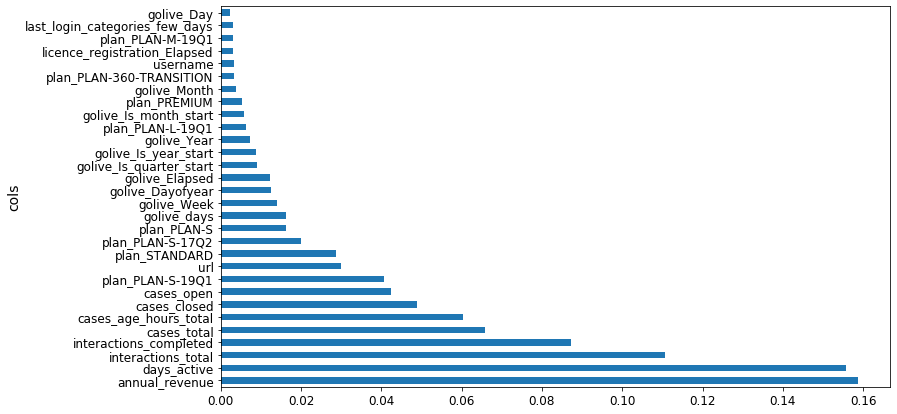

In [807]:
plot_fi(fi[:30]);

In [808]:
from scipy.cluster import hierarchy as hc

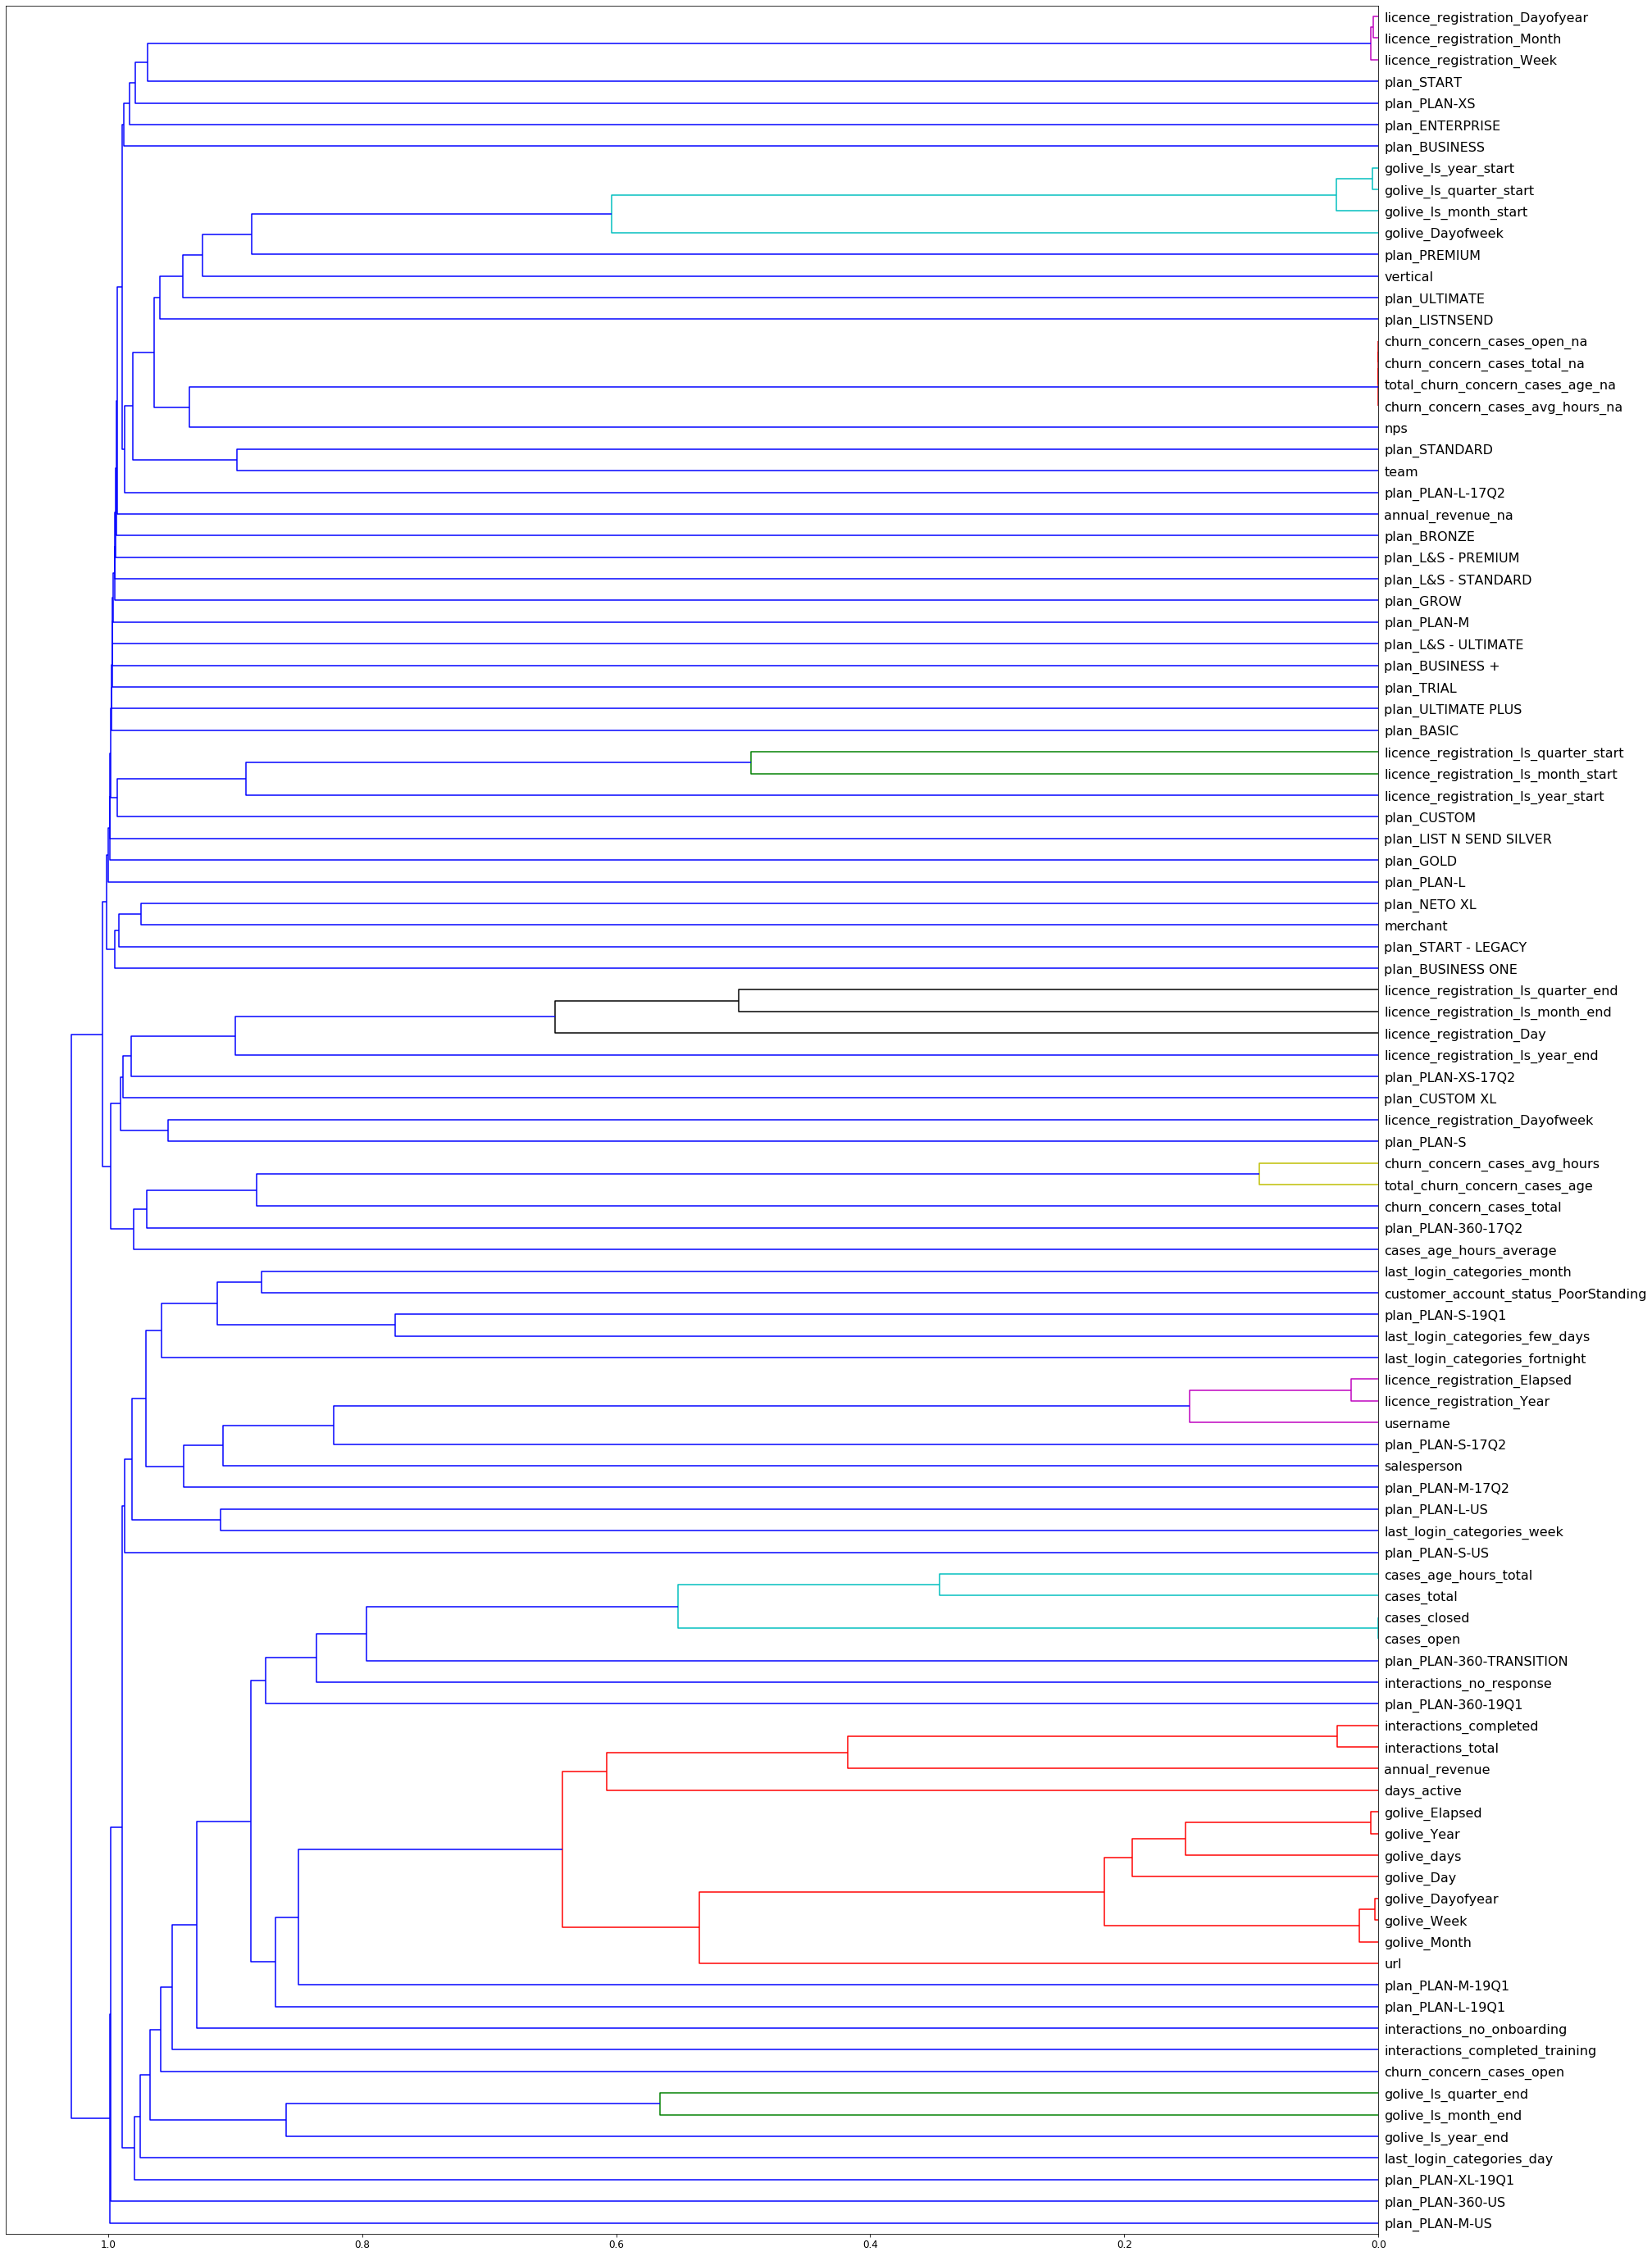

In [809]:
corr = np.round(scipy.stats.spearmanr(df_trn).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(30,50))
dendrogram = hc.dendrogram(z, labels=df_trn.columns, orientation='left', leaf_font_size=16)
plt.show()

In [865]:
def remove_columns_test(df):
    m = RandomForestClassifier(
        n_estimators=10,
        min_samples_leaf=1, 
        max_features='sqrt',
        n_jobs=-1, 
        #oob_score=True,
        max_depth=3,
        bootstrap=False,
        criterion='gini',
        class_weight={0: 2, 1: 1})
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    y_pred = m.predict(x)
    return uber_score(y_train, y_pred)

In [866]:
dataframe_data = []
for c in (df_trn):
    array = []
    array.append(c)
    array.extend(remove_columns_test(df_trn.drop(c, axis=1)))
    remove_columns_test(df_trn.drop(c, axis=1))
    dataframe_data.append(array)

In [867]:
# Create the pandas DataFrame
df_plot = pd.DataFrame(dataframe_data, columns = ['removed_column', 'precision', 'recall', 'f1_score', 'accuracy', 'kappa', 'mae'])

In [868]:
df_plot['column_code'] = df_plot.removed_column.astype("category").cat.codes

In [869]:
import hvplot.pandas

df_plot.hvplot(x='column_code', y=['recall', 'f1_score', 'accuracy', 'kappa', 'mae'], kind='scatter')

:NdOverlay   [Variable]
   :Scatter   [column_code]   (value)

In [875]:
df_plot[df_plot.column_code.isin([33,78,62,64])]

,removed_column,precision,recall,f1_score,accuracy,kappa,mae,column_code
15,interactions_total,0.988040,0.709379,0.825836,0.831880,0.671611,0.168120,33
38,plan_GOLD,0.986331,0.762550,0.860123,0.860642,0.725738,0.139358,62
40,plan_L&S - PREMIUM,0.971591,0.790621,0.871814,0.869364,0.741464,0.130636,64
54,plan_PLAN-M,0.959881,0.853369,0.903497,0.897569,0.795162,0.102431,78


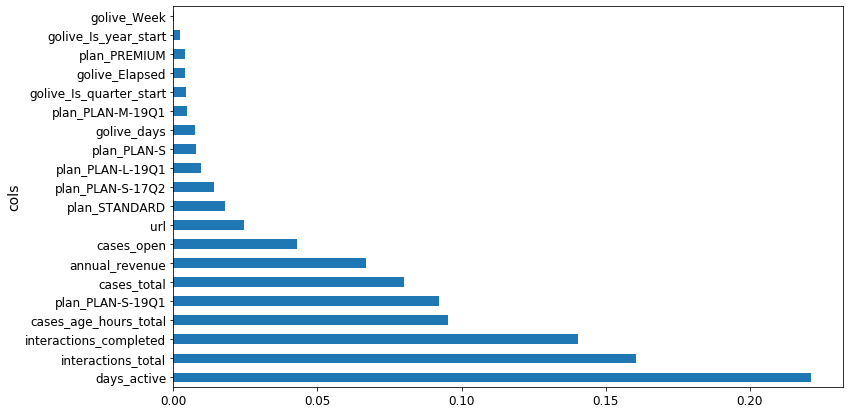

In [651]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);